In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from batman import TransitModel
from astropy.io import fits
import astropy.units as u
from astropy.time import Time

from linea import CheopsLightCurve, params_55Cnce

p = params_55Cnce()

In [2]:
lc = CheopsLightCurve.from_example()

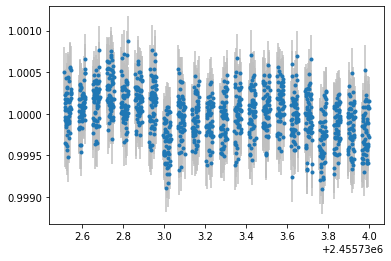

In [3]:
lc.plot(fmt='.', ecolor='silver')

Text(0, 0.5, 'Y')

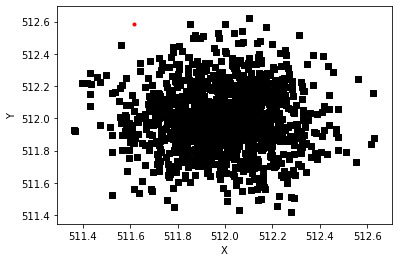

In [4]:
lc.sigma_clip_centroid(plot=True)

plt.xlabel('X')
plt.ylabel('Y')

In [5]:
transit_model_offset = TransitModel(p, lc.bjd_time[~lc.mask], 
                                    supersample_factor=3, 
                                    exp_time=lc.bjd_time[1] - lc.bjd_time[0],
                                    ).light_curve(p) - 1

# Build a design matrix
X = np.hstack([    
    # Transit model: 
    transit_model_offset[:, None],

    # Sinusoidal phase curve trend: 
    np.sin(2 * np.pi * (lc.bjd_time[~lc.mask] - lc.bjd_time.mean()) / p.per)[:, None], 
    np.cos(2 * np.pi * (lc.bjd_time[~lc.mask] - lc.bjd_time.mean()) / p.per)[:, None],
    
    # Default design matrix: 
    lc.design_matrix(), 
])


In [6]:
r = lc.regress(X)

In [7]:
t_fine = np.linspace(lc.bjd_time.min(), lc.bjd_time.max(), 1000)

transit_fine = TransitModel(p, t_fine, 
                            supersample_factor=3, 
                            exp_time=lc.bjd_time[1] - lc.bjd_time[0],
                            ).light_curve(p)

sinusoid_fine = (np.hstack([
    np.sin(2 * np.pi * (t_fine - t_fine.mean()) / p.per)[:, None], 
    np.cos(2 * np.pi * (t_fine - t_fine.mean()) / p.per)[:, None], 
]) @ r.betas[1:3]) / np.median(r.best_fit)

Reconstructed phase curve amplitude: 189 ± 14 ppm (truth = 175 ppm)


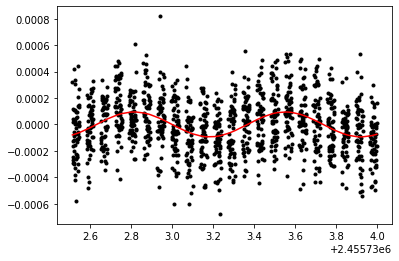

In [8]:
sinusoid = X[:, 1:3] @ r.betas[1:3]

preserve_sinusoid = sinusoid + (lc.flux[~lc.mask] - r.best_fit)

print(f"Reconstructed phase curve amplitude: {1e6 * sinusoid.ptp():.0f} ± " +
      f"{1e6 * np.max(np.sqrt(np.diag(r.cov))[1:3]):.0f} ppm (truth = 175 ppm)")

plt.plot(lc.bjd_time[~lc.mask], preserve_sinusoid, 'k.')
plt.plot(lc.bjd_time[~lc.mask], sinusoid, 'r')

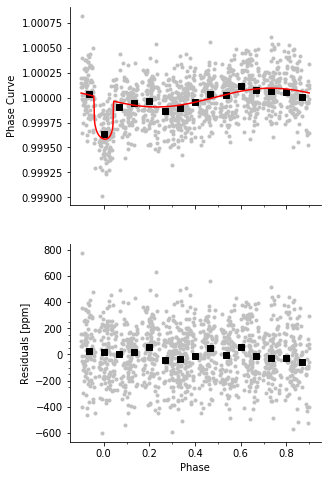

In [16]:
from scipy.stats import binned_statistic

n_regressors = 2
bins = 15
t0_offset = 0

transit = r.X[:, 0] * r.betas[0]
# eclipse = r.X[:, -1] * r.betas[-1]
# eclipse_fine = (TransitModel(p, t_fine - t0_offset, 
#                             supersample_factor=3, 
#                             exp_time=lc.bjd_time[1] - lc.bjd_time[0],
#                             transittype='secondary'
#                             ).light_curve(p) - 1) * r.betas[-1]
# eclipse_fine -= eclipse_fine.max()
eclipse = eclipse_fine = 0

sinusoid = (r.X[:, 1:n_regressors+1] @ r.betas[1:n_regressors+1]) # /
#             r.best_fit)

phases = ((lc.bjd_time[~lc.mask] - p.t0 - t0_offset) %
          p.per) / p.per
wrap_phase = 0.9
phases[phases > wrap_phase] -= 1
phases_fine = (((t_fine - p.t0 - t0_offset) % p.per) /
               p.per)
phases_fine[phases_fine > wrap_phase] -= 1

fig, ax = plt.subplots(2, 1, figsize=(4.5, 8), sharex=True)
ax[0].plot(phases, (transit + 1 + eclipse) * (
        lc.flux[~lc.mask] / r.best_fit + sinusoid), '.',
           color='silver')

bs = binned_statistic(phases,
                      (transit + 1 + eclipse) * (lc.flux[~lc.mask] /
                                       r.best_fit + sinusoid),
                      bins=bins, statistic='median')

bs_counts = binned_statistic(phases, lc.flux[~lc.mask],
                             bins=bins, statistic=np.count_nonzero).statistic
counts_mask = bs_counts > 35

bincenters = 0.5 * (bs.bin_edges[1:] + bs.bin_edges[:-1])

ax[0].plot(bincenters[counts_mask], bs.statistic[counts_mask], 
           's', color='k')

ax[0].plot(phases_fine[np.argsort(phases_fine)],
           (transit_fine + sinusoid_fine + eclipse_fine)[np.argsort(phases_fine)], 'r')

ax[0].set(ylabel='Phase Curve')

bs_resid = binned_statistic(phases,
                            lc.flux[~lc.mask] / r.best_fit - 1,
                            bins=bins, statistic='median')

ax[1].plot(phases, 1e6 * (lc.flux[~lc.mask] / r.best_fit - 1), '.',
           color='silver')
ax[1].plot(bincenters[counts_mask], 1e6 * bs_resid.statistic[counts_mask], 
           's', color='k')

ax[1].set(ylabel='Residuals [ppm]', xlabel='Phase')
ax[1].set_xticks(np.arange(-0, 1, 0.1), minor=True)
# ax[1].set_ylim([-2.5e-4, 2.5e-4])
ax[1].set_yticks(np.arange(-250, 300, 50), minor=True)
for axis in ax:
    for sp in ['right', 'top']:
        axis.spines[sp].set_visible(False)
ax[0].ticklabel_format(useOffset=False)
